
# Test clouds: 

Objective:

   * Test non differencial features, gradient, laplace
   
   * Test in 2D and 3D


### JAH, May 2021

In [1]:
%matplotlib inline
#%matplotlib notebook
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy             as np
import matplotlib.pyplot as plt
import scipy.ndimage     as ndimg

import clouds.clouds    as clouds
import clouds.pltclouds as pltclouds

import clouds.ridges      as ridges
import clouds.test_ridges as tridges

In [3]:
plt.rcParams['image.cmap'] = 'rainbow'

In [4]:
import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Wed May 26 18:25:29 2021


## Test

   * Introduce an gaussian scale in the image
   
   * test the maximum gradient 


## Generate Function

In [5]:
fig  = lambda nx = 1, ny = 1, sz = 5 : plt.figure(figsize = (ny * sz, nx * sz))
ax3d = lambda nx = 1, ny = 1, i = 1  : plt.gcf().add_subplot(nx, ny, i, projection = '3d')
hopts = {'histtype' : 'step'}
efig = plt.tight_layout
cells_select = clouds.cells_select

## Generate image

In [42]:
sigma = 1
from scipy.stats import norm

nbins = 40
x = np.linspace(0, 5, nbins)
y = np.linspace(0, 10, nbins)
bins = (x, y)
steps = [bin[1] - bin[0] for bin in bins]
#fun = lambda x, y : norm.pdf( np.sqrt(x*x + y* y), scale = sigma)
y0   = 5
fun = lambda x, y : x - (y-y0)**2
centers  = [clouds.ut_centers(bin) for bin in bins] 

xmesh = np.meshgrid(*centers, indexing = 'ij')
img   = fun(*xmesh)
img   -= np.min(img) 

In [43]:
mask  = img >= -100
cells = [x[mask] for x in xmesh]
enes  = img[mask]

## Img and cloud

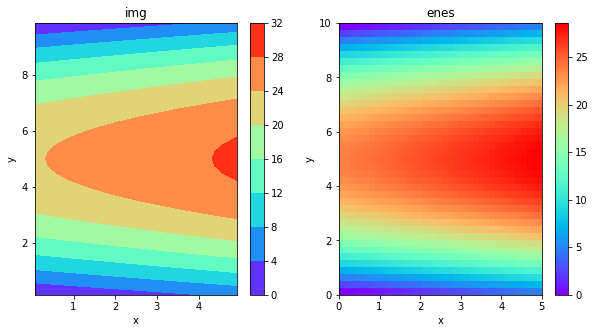

In [44]:
mask  = img >= -100
cells = [x[mask] for x in xmesh]
enes  = img[mask]

fig(1, 2)
plt.subplot(1, 2, 1)
plt.contourf(*xmesh, img);
plt.colorbar();
plt.xlabel('x'); plt.ylabel('y'); plt.title('img');

plt.subplot(1, 2, 2)
plt.hist2d(*cells, bins, weights = enes);
plt.colorbar();
plt.xlabel('x'); plt.ylabel('y'); plt.title('enes');

## Gradient and Edge Filter

In [45]:
egrad, epath, edir = clouds.gradient_to_neighbour_direction(bins, mask, cells, enes)
edge = clouds.edge_filter(bins, mask, cells, egrad, edir)

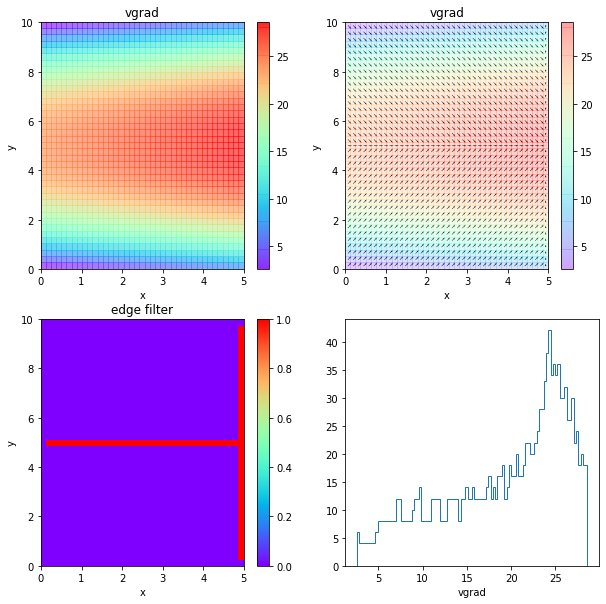

In [46]:
ndim = 2
opts = {'scale_units': 'xy', 'scale' : 10} if ndim == 2 else {'length' : 0.4}
xdir = [edir[..., i] for i in range(ndim)]

fig(2, 2)
plt.subplot(2, 2, 1)
#plt.gca().quiver(*cells, *xdir, **opts)
plt.hist2d(*cells, bins, weights = egrad, alpha = 0.6);
plt.xlabel('x'); plt.ylabel('y'); plt.title('vgrad');
plt.colorbar();

plt.subplot(2, 2, 2)
plt.gca().quiver(*cells, *xdir, **opts)
plt.hist2d(*cells, bins, weights = egrad, alpha = 0.2);
plt.xlabel('x'); plt.ylabel('y'); plt.title('vgrad');
plt.colorbar();

plt.subplot(2, 2, 3)
plt.hist2d(*cells, bins, weights = edge, alpha = 1.);
plt.xlabel('x'); plt.ylabel('y'); plt.title('edge filter');
plt.colorbar();

plt.subplot(2, 2, 4)
plt.hist(egrad.flatten(), 100, **hopts);
plt.xlabel('vgrad');

## Laplace

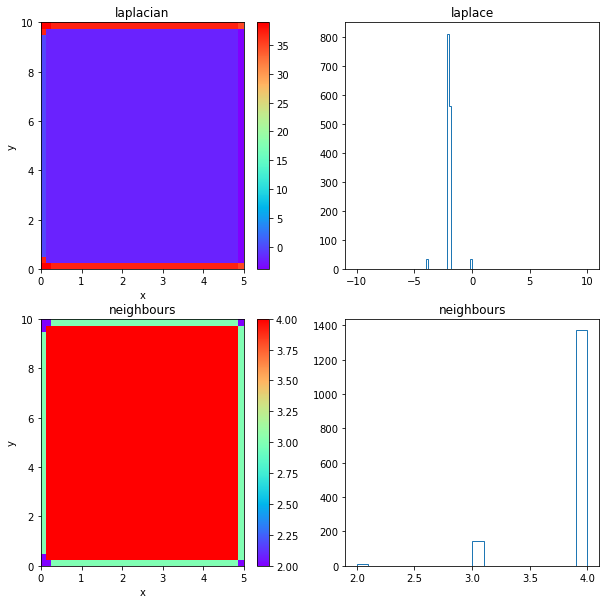

In [47]:
lap, neigh = clouds.laplace(bins, mask, cells, enes)

fig(2, 2)
plt.subplot(2, 2, 1)
plt.hist2d(*cells, bins, weights = lap);
plt.colorbar();
plt.xlabel('x'); plt.ylabel('y'); plt.title('laplacian');

plt.subplot(2, 2, 2)
plt.hist(lap.flatten(), 100, (-10, 10), **hopts);
plt.title('laplace');

plt.subplot(2, 2, 3)
plt.hist2d(*cells, bins, weights = neigh);
plt.xlabel('x'); plt.ylabel('y'); plt.title('neighbours');
plt.colorbar();

plt.subplot(2, 2, 4)
plt.hist(neigh.flatten(), 20, **hopts);
plt.title('neighbours');

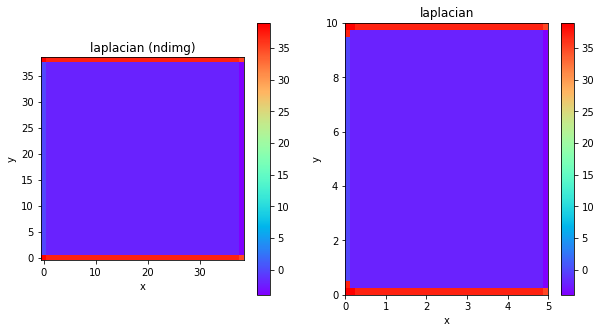

In [50]:
lap2 = ndimg.laplace(img)

vol = np.prod(steps)

fig(1, 2)
plt.subplot(1, 2, 1)
plt.imshow(lap2.T/(ndim * vol), origin = 'lower')
plt.colorbar();
plt.xlabel('x'); plt.ylabel('y'); plt.title('laplacian (ndimg)');

plt.subplot(1, 2, 2)
plt.hist2d(*cells, bins, weights = lap);
plt.colorbar();
plt.xlabel('x'); plt.ylabel('y'); plt.title('laplacian');


### Debug Transverse Laplace

In [51]:
direction  = [np.histogramdd(cells, bins, weights = edir[:, i])[0] \
                for i in range(ndim)]

def _debug_move(move):
    coors_next        = [cells[i] + steps[i] * move[i] for i in range(ndim)]
    potential_next, _ = np.histogramdd(coors_next, bins, weights = enes)

    sel_pot           = potential_next > 0.
    vdot              = np.zeros(potential_next.shape)
    for i in range(ndim):
        vdot += direction[i] * move[i]
    sel_trans = np.isclose(vdot, 0)
    
    #plt.imshow(vdot.T, origin = 'lower');
    plt.imshow(sel_trans.T, origin = 'lower');
    plt.title(str(move))
    #plt.colorbar();
        

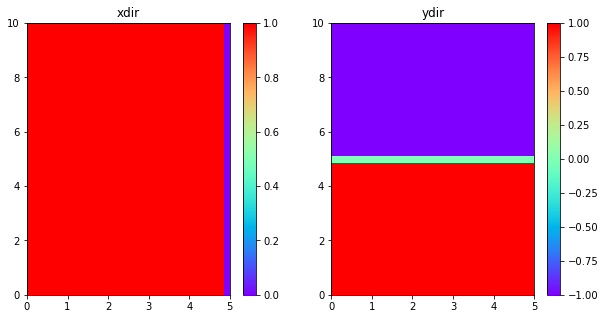

In [52]:
fig(1, 2)
plt.subplot(1, 2, 1)
plt.hist2d(*cells, bins, weights = edir[:, 0])
plt.title('xdir'); plt.colorbar();
plt.subplot(1, 2, 2)
plt.hist2d(*cells, bins, weights = edir[:, 1]);
plt.title('ydir'); plt.colorbar();

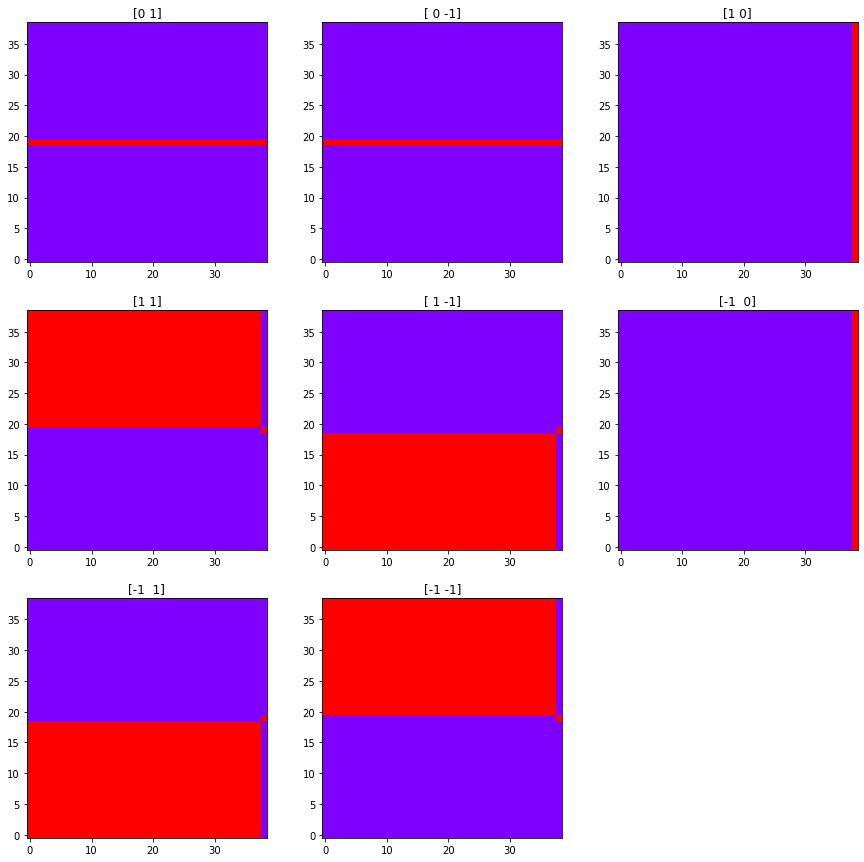

In [53]:
ndim = 2
fig(3, 3)
for i, move in enumerate(clouds.moves(ndim)):
    plt.subplot(3, 3, i + 1)
    _debug_move(move)

## Transverse laplace

In [54]:
lap_trans, neigh_trans = clouds.laplace_transverse(bins, mask, cells, enes, edir)

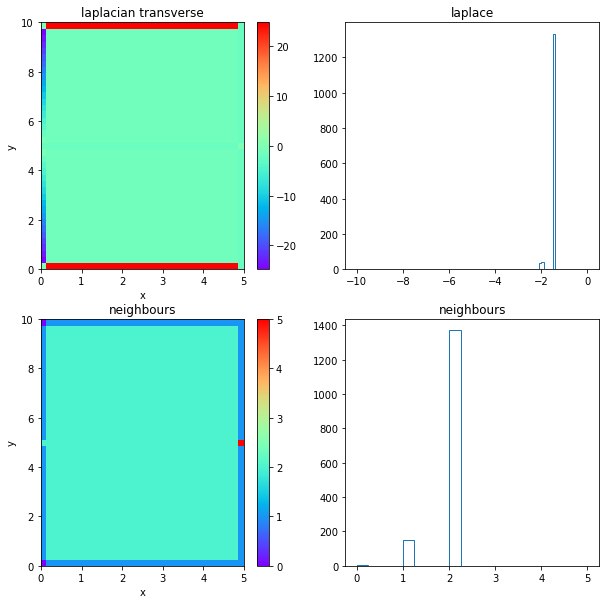

In [55]:
fig(2, 2)
plt.subplot(2, 2, 1)
plt.hist2d(*cells, bins, weights = lap_trans);
plt.colorbar();
plt.xlabel('x'); plt.ylabel('y'); plt.title('laplacian transverse');

plt.subplot(2, 2, 2)
plt.hist(lap_trans.flatten(), 100, (-10, 0), **hopts);
plt.title('laplace');

plt.subplot(2, 2, 3)
plt.hist2d(*cells, bins, weights = neigh_trans);
plt.xlabel('x'); plt.ylabel('y'); plt.title('neighbours');
plt.colorbar();

plt.subplot(2, 2, 4)
plt.hist(neigh_trans.flatten(), 20, **hopts);
plt.title('neighbours');

### Ridge Filter

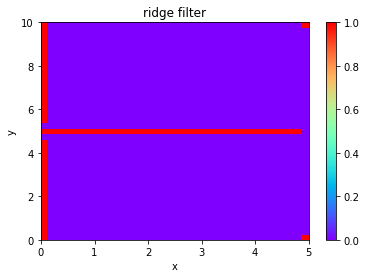

In [57]:
ridge = clouds.ridge_filter(bins, mask, cells, enes, edir)
plt.hist2d(*cells, bins, weights = ridge);
plt.colorbar();
plt.xlabel('x'); plt.ylabel('y'); plt.title('ridge filter');

## In 3D

In [68]:
nbins = 40
x = np.linspace(0,  5, nbins)
y = np.linspace(0, 10, nbins)
z = np.linspace(0, 10, nbins)
bins = (x, y, z)
steps = [bin[1] - bin[0] for bin in bins]
#fun = lambda x, y : norm.pdf( np.sqrt(x*x + y* y), scale = sigma)
y0, z0   = 5, 3
fun = lambda x, y, z : x * x - (y-y0)**2 - 0.5 * (z - z0)**2
centers  = [clouds.ut_centers(bin) for bin in bins] 

xmesh = np.meshgrid(*centers, indexing = 'ij')
img   = fun(*xmesh)
img   -= np.min(img) 

ndim  = len(bins)
mask  = img > 0
cells = [x[mask].flatten() for x in xmesh]
enes  = img[mask].flatten()
print('dimensions ', mask.shape, len(cells[0]))

dimensions  (39, 39, 39) 59317


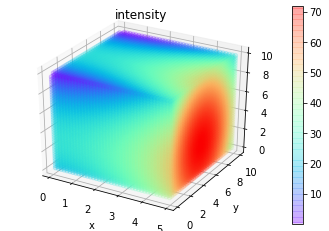

In [69]:
def _plot3d(var, name):
    p = plt.gca().scatter(*cells, '.', c = var.flatten(), alpha = 0.2);
    plt.xlabel('x'); plt.ylabel('y'); plt.title(name); plt.colorbar(p);

#counts, _ = np.histogramdd([x.flatten() for x in xmesh], bins, weights = img.flatten())
#assert (np.all(counts == img)) # Test the the img is the same ad the histogram


ax = ax3d();
_plot3d(enes, 'intensity')

## Gradient

In [70]:
egrad, epath, edir = clouds.gradient_to_neighbour_direction(bins, mask, cells, enes)

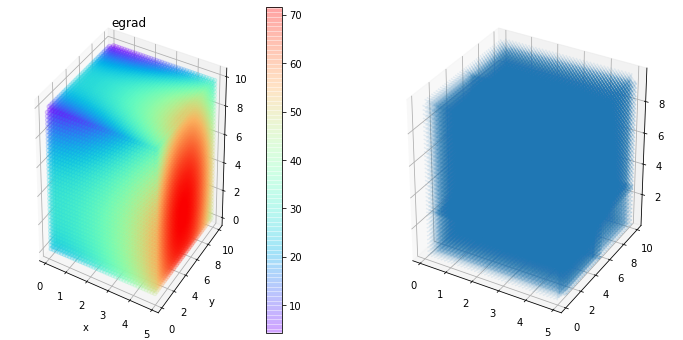

In [71]:
xdirs =[edir[:, i] for i in range(ndim)]
opts = {'scale_units': 'xy', 'scale' : 2.} if ndim == 2 else {'length' : 0.4}

fig(1, 2, 6)
ax = ax3d(1, 2, 1)
_plot3d(egrad, 'egrad');

ax = ax3d(1, 2, 2)
opts = {'scale_units': 'xy', 'scale' : 2.} if ndim == 2 else {'length' : 0.4}
xdirs = [edir[:, i] for i in range(ndim)]
plt.gca().quiver(*cells, *xdirs, **opts, alpha = 0.1);


### Edge Filter

In [72]:
edge = clouds.edge_filter(bins, mask, cells, egrad, edir)

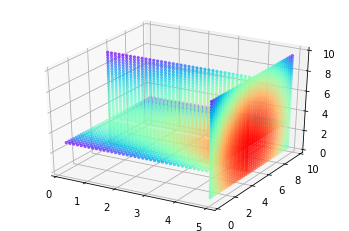

In [73]:
ax = ax3d()
plt.gca().scatter(*cells_select(cells, edge), c = enes[edge], marker = '.');

## Laplace

2.4041804076065065e-14


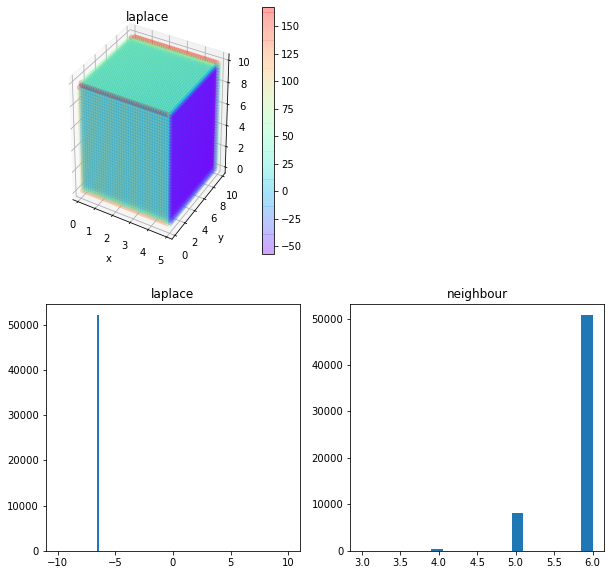

In [76]:
lap, neigh = clouds.laplace(bins, mask, cells, enes)

lap2 = ndimg.laplace(img)
print(np.mean(lap))

fig(2, 2)
ax = ax3d(2, 2, 1)
_plot3d(lap, 'laplace')

plt.subplot(2, 2, 3)
plt.hist(lap.flatten(), 100, (-10, 10));
plt.title('laplace')

plt.subplot(2, 2, 4)
plt.hist(neigh.flatten(), 20);
plt.title('neighbour');

## Transverse laplacian

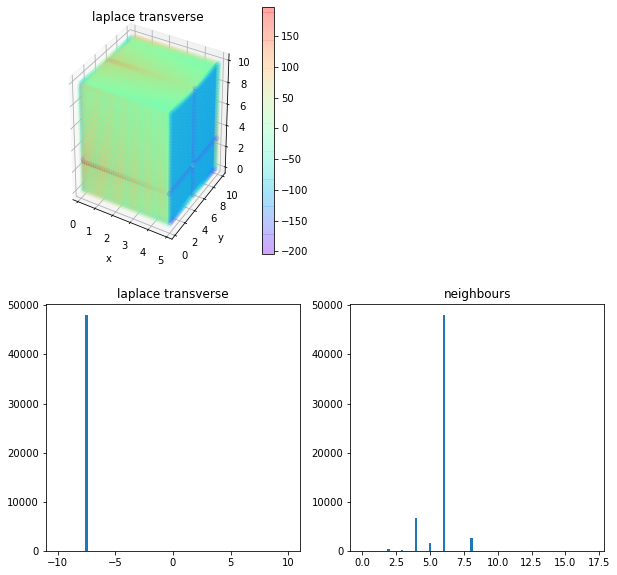

In [77]:
lap_t, neigh_t = clouds.laplace_transverse(bins, mask, cells, enes, edir)

fig(2, 2)
ax = ax3d(2, 2, 1)
_plot3d(lap_t, 'laplace transverse')

plt.subplot(2, 2, 3)
plt.hist(lap_t.flatten(), 100, (-10, 10));
plt.title('laplace transverse')

plt.subplot(2, 2, 4)
plt.hist(neigh_t.flatten(), 100);
plt.title('neighbours');


## Ridge Filter

In [78]:
ridge = clouds.ridge_filter(bins, mask, cells, enes, edir)

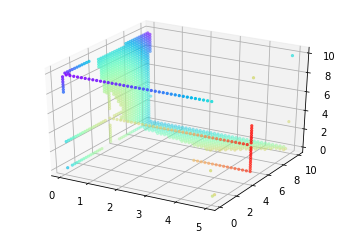

In [79]:
ax = ax3d()
plt.gca().scatter(*cells_select(cells, ridge), c = enes[ridge], marker = '.');